In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn scipy shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import shap
import joblib


/Users/thilakna/Desktop/personality predictor/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('personality_dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


### Basic Exploratory Data Analysis

Missing values per column:
 Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64

Number of duplicate rows: 388

Class distribution:
 Personality
Extrovert    1491
Introvert    1409
Name: count, dtype: int64


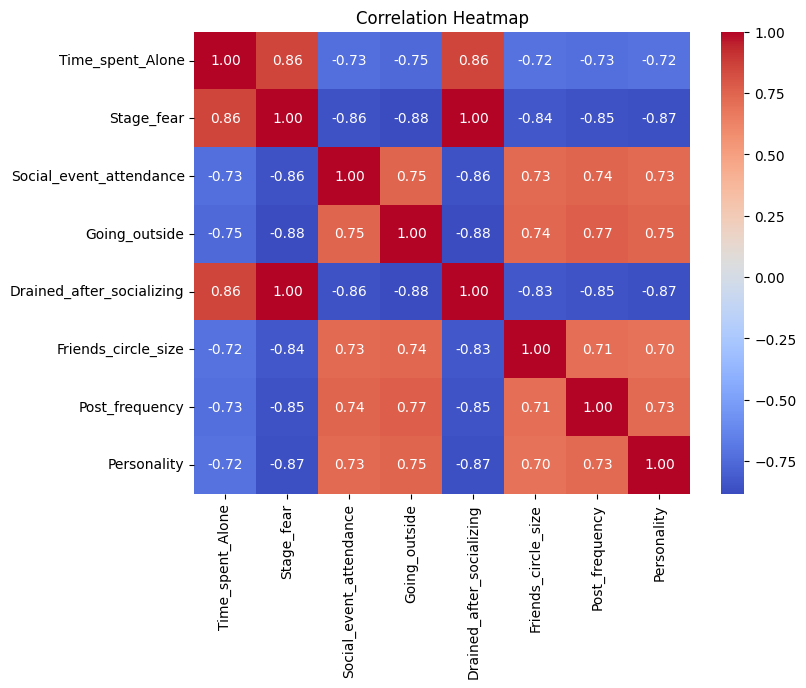

In [5]:
# 1. Find missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# 2. Find duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# 3. Check for class imbalance
class_counts = df['Personality'].value_counts()
print("\nClass distribution:\n", class_counts)


# 4. Heatmap for feature importance (correlation with target)
# Convert categorical columns to numeric for correlation
df_encoded = df.copy()
df_encoded['Stage_fear'] = df_encoded['Stage_fear'].map({'Yes': 1, 'No': 0})
df_encoded['Drained_after_socializing'] = df_encoded['Drained_after_socializing'].map({'Yes': 1, 'No': 0})
df_encoded['Personality'] = df_encoded['Personality'].map({'Introvert': 0, 'Extrovert': 1})
# Compute correlation matrix
corr = df_encoded.corr()
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# remove duplicates
df = df.drop_duplicates()

### Feature Engineering - Numerical


In [7]:
numerical_features = ['Going_outside', 'Time_spent_Alone', 'Social_event_attendance', 'Friends_circle_size','Post_frequency']

In [8]:
for col in numerical_features:
    col_skew = skew(df[col].dropna())
    col_kurt = kurtosis(df[col].dropna())
    print(f"{col}: skewness = {col_skew:.2f}, kurtosis = {col_kurt:.2f}")


Going_outside: skewness = 0.05, kurtosis = -1.27
Time_spent_Alone: skewness = 0.53, kurtosis = -1.01
Social_event_attendance: skewness = 0.16, kurtosis = -1.20
Friends_circle_size: skewness = 0.29, kurtosis = -1.11
Post_frequency: skewness = 0.34, kurtosis = -1.17


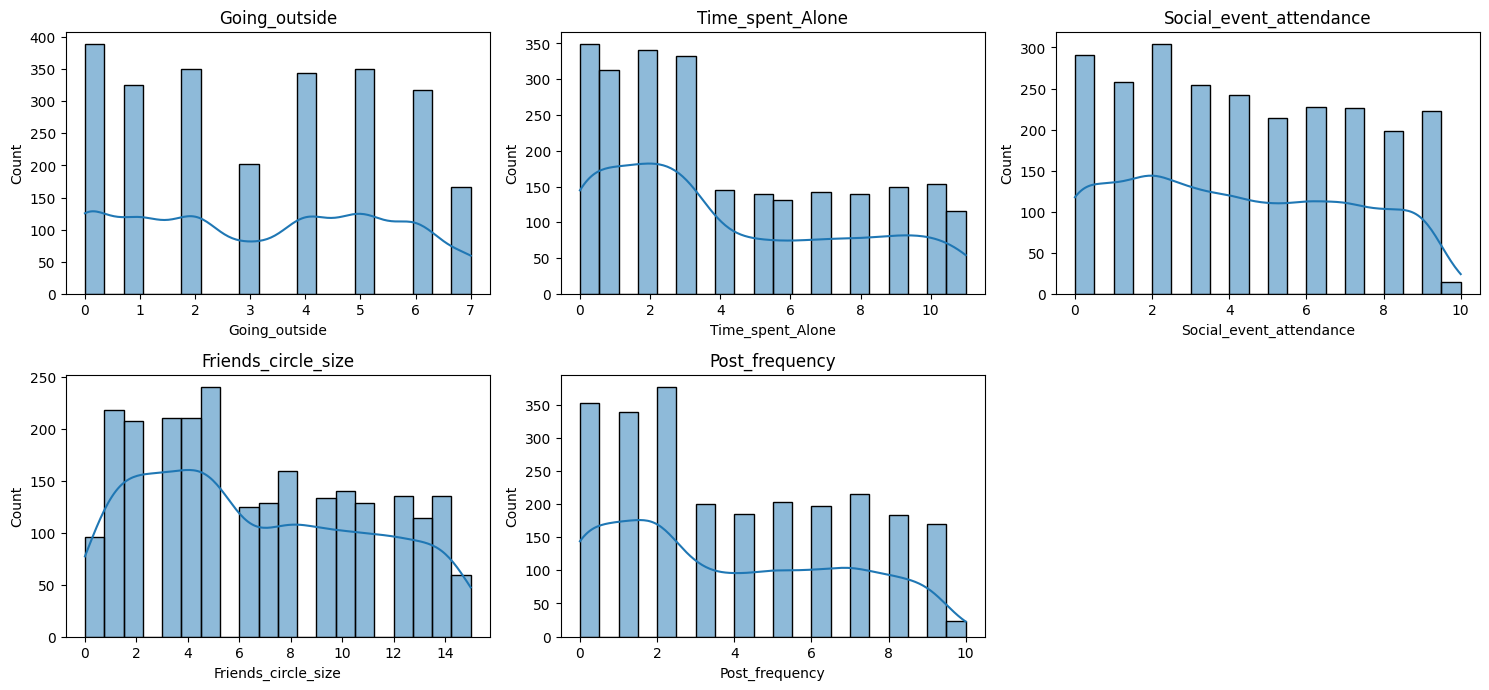

In [9]:
# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

In [10]:


impute_strategies = {
    "Going_outside": "mean",
    "Time_spent_Alone": "median",
    "Social_event_attendance": "mean",
    "Friends_circle_size": "median",
    "Post_frequency": "median"
}

for col, strat in impute_strategies.items():
    imputer = SimpleImputer(strategy=strat)
    df[[col]] = imputer.fit_transform(df[[col]])


In [11]:
df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.000000,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.000000,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.000000,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.000000,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.000000,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2894,0.0,No,9.0,3.000000,No,12.0,3.0,Extrovert
2896,3.0,No,8.0,3.000000,No,14.0,9.0,Extrovert
2897,4.0,Yes,1.0,1.000000,Yes,4.0,0.0,Introvert
2898,11.0,Yes,1.0,3.203923,Yes,2.0,0.0,Introvert


### Feature engineering - Categorical

In [12]:
# Impute categorical columns with mode
categorical_cols = ['Stage_fear', 'Drained_after_socializing']


for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

/var/folders/p3/jw_6msnx2gn1_xcl6ptwmtmc0000gn/T/ipykernel_49674/2941866599.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [13]:
df_cleaned = df.copy()
df_cleaned['Personality'] = df_cleaned['Personality'].map({'Introvert': 0, 'Extrovert': 1})
df_cleaned['Stage_fear'] = df_cleaned['Stage_fear'].map({'No': 0, 'Yes': 1})
df_cleaned['Drained_after_socializing'] = df_cleaned['Drained_after_socializing'].map({'No': 0, 'Yes': 1})

In [14]:
df_cleaned

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,0,4.0,6.000000,0,13.0,5.0,1
1,9.0,1,0.0,0.000000,1,0.0,3.0,0
2,9.0,1,1.0,2.000000,1,5.0,2.0,0
3,0.0,0,6.0,7.000000,0,14.0,8.0,1
4,3.0,0,9.0,4.000000,0,8.0,5.0,1
...,...,...,...,...,...,...,...,...
2894,0.0,0,9.0,3.000000,0,12.0,3.0,1
2896,3.0,0,8.0,3.000000,0,14.0,9.0,1
2897,4.0,1,1.0,1.000000,1,4.0,0.0,0
2898,11.0,1,1.0,3.203923,1,2.0,0.0,0


### Model Training

In [ ]:

df = df_cleaned
X = df.drop('Personality', axis=1)

# based on correlation analysis
X = X.drop("Drained_after_socializing", axis=1)
y = df['Personality']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

param_grid = {
    'n_estimators': [500],
    'max_depth': [7,8,9,10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.8],
    'gamma': [1]
}
grid = GridSearchCV(
    xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
Best CV accuracy: 0.9283160258557587


### Model Evaluation

Test Accuracy: 0.9105367793240556
Recall: 0.94, Precision: 0.91


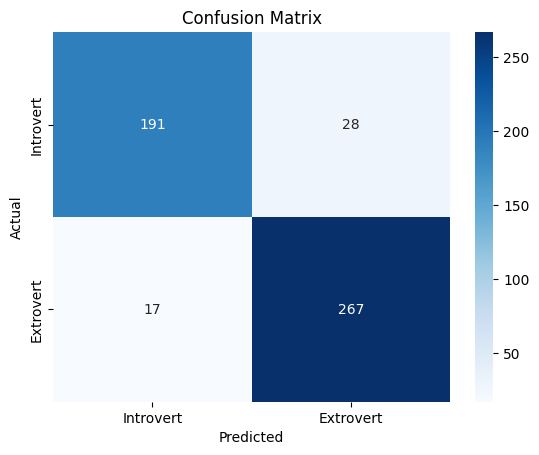

In [16]:
y_test_pred = grid.best_estimator_.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
print(f"Recall: {recall:.2f}, Precision: {precision:.2f}")
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Introvert', 'Extrovert'], yticklabels=['Introvert', 'Extrovert'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Time_spent_Alone: 0.0108
Stage_fear: 0.9575
Social_event_attendance: 0.0069
Going_outside: 0.0060
Friends_circle_size: 0.0056
Post_frequency: 0.0131


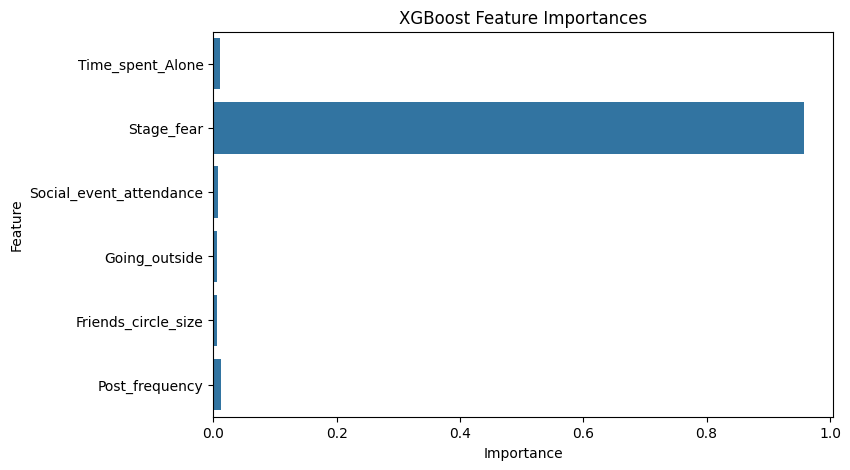

In [17]:

feature_importances = grid.best_estimator_.feature_importances_
features = X.columns

for feat, imp in zip(features, feature_importances):
    print(f"{feat}: {imp:.4f}")


plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=features)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [20]:
    
best_model = grid.best_estimator_

joblib.dump(best_model, "personality_model.pkl")



['personality_model.pkl']

### Inference

In [21]:
import pandas as pd
import joblib

# Example input
new_data = pd.DataFrame([{
    'Time_spent_Alone': 0.05,
    'Stage_fear': 0,
    'Social_event_attendance': 0.2,
    'Going_outside': 1.0,
    'Friends_circle_size': 0.3,
    'Post_frequency': 10
}])

# Load model
loaded_model = joblib.load('personality_model.pkl')

# Predict
prediction = loaded_model.predict(new_data)
prediction_proba = loaded_model.predict_proba(new_data)

print("Predicted Personality:", "Extrovert" if prediction[0] == 1 else "Introvert")
print("Probability of Extrovert:", prediction_proba[0][1])


Predicted Personality: Extrovert
Probability of Extrovert: 0.91168
